In [1]:
!rm -rf calling-out-bluff/
!git clone https://github.com/SwapnilDreams100/calling-out-bluff.git

Cloning into 'calling-out-bluff'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 3471 (delta 3), reused 12 (delta 2), pack-reused 3455
Receiving objects: 100% (3471/3471), 908.76 MiB | 37.76 MiB/s, done.
Resolving deltas: 100% (711/711), done.
Checking out files: 100% (3481/3481), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install xhtml2pdf
# !wget http://nlp.stanford.edu/data/glove.6B.zip
! cp ./drive/My\ Drive/glove.6B.300d.txt ./calling-out-bluff/Model5-MemoryNets/
! cp ./drive/My\ Drive/glove.6B.300d.txt ./calling-out-bluff/Model5-MemoryNets/glove

     |████████████████████████████████| 102kB 5.2MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 2.6MB 12.2MB/s 
  Created wheel for xhtml2pdf: filename=xhtml2pdf-0.2.5-cp36-none-any.whl size=234491 sha256=c416d4bc559f55da78dc156cdc36446cb0a84dc77c5380b25d0e8ab78ab138c2
  Stored in directory: /root/.cache/pip/wheels/69/0f/15/6f8008b18ca84c08c198445b465c8038f745e444d7251a8266
  Created wheel for pyPdf2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61087 sha256=101b77986e83a5a1ad60d186fc2414de2e2b5ef4c9ff5073ebe13a20c2b9acf4
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.1-cp36-none-any.whl size=16504 sha256=488e33e0688b257985ece8a2cb9dd428cb804656dfb43d13b39327b7fb218c5b
  Stored in directory: /root/.cache/pip/wheels/62/52/d8/bd0dcbf00f9e77e3bd0184285ed77dfa9c475dac494a5353d1
Successfully built xhtml2pdf pyPdf2

In [4]:
%cd calling-out-bluff/Model5-MemoryNets/
%tensorflow_version 1.x
import data_utils
import numpy as np
from sklearn.model_selection import KFold
from qwk import quadratic_weighted_kappa
import tensorflow as tf
import time
import os
import sys
import pickle
import pandas as pd

early_stop_count = 0
max_step_count = 10
is_regression =  False
gated_addressing = False
essay_set_id = 3
batch_size = 15
embedding_size = 300
feature_size = 100
l2_lambda = 0.3
hops = 3
reader = 'bow' # gru may not work
epochs = 100
num_samples = 1
num_tokens = 42
test_batch_size = batch_size
random_state = 0

/content/calling-out-bluff/Model5-MemoryNets
TensorFlow 1.x selected.


In [5]:
if is_regression:
    from memn2n_kv_regression import MemN2N_KV
else:
    from memn2n_kv import MemN2N_KV
# print flags info
orig_stdout = sys.stdout
timestamp = time.strftime("%b_%d_%Y_%H:%M:%S", time.localtime())
folder_name = '{}'.format(essay_set_id)
out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs/", folder_name))
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# save output to a file
#f = file(out_dir+'/out.txt', 'w')
#sys.stdout = f
print("Writing to {}\n".format(out_dir))

# hyper-parameters end here
training_path = 'training_set_rel3.tsv'
essay_list, resolved_scores, essay_id = data_utils.load_training_data(training_path, essay_set_id)

max_score = max(resolved_scores)
min_score = min(resolved_scores)
if essay_set_id == 7:
    min_score, max_score = 0, 30
elif essay_set_id == 8:
    min_score, max_score = 0, 60

print( 'max_score is {} \t min_score is {}\n'.format(max_score, min_score))
with open(out_dir+'/params', 'a') as f:
    f.write('max_score is {} \t min_score is {} \n'.format(max_score, min_score))

Writing to /content/calling-out-bluff/Model5-MemoryNets/runs/3

max_score is 3 	 min_score is 0



In [6]:
# if essay_set_id == 7:
#     min_score, max_score = 0, 30
# elif essay_set_id == 8:
#     min_score, max_score = 0, 60

score_range = range(min_score, max_score+1)

# #word_idx, _ = data_utils.build_vocab(essay_list, vocab_limit)

# load glove
import data_utils
word_idx, word2vec = data_utils.load_glove(42, dim=300)

with open('tokenizer.pkl', 'wb') as f:
  pickle.dump( word_idx,f)

# vocab_size = len(word_idx) + 1
# # stat info on data set

# sent_size_list = list(map(len, [essay for essay in essay_list]))
# # print("sent size list", sent_size_list)
# max_sent_size = max(sent_size_list)
# mean_sent_size = int(np.mean(sent_size_list))

# print( 'max sentence size: {} \nmean sentence size: {}\n'.format(max_sent_size, mean_sent_size))
# with open(out_dir+'/params', 'a') as f:
#     f.write('max sentence size: {} \nmean sentence size: {}\n'.format(max_sent_size, mean_sent_size))

# print( 'The length of score range is {}'.format(len(score_range)))
# E = data_utils.vectorize_data(essay_list, word_idx, max_sent_size)
# # print(vocab_size)
# labeled_data = zip(E, resolved_scores, sent_size_list)

==> glove is loaded


In [ ]:
def train_step(m, e, s, ma):
    start_time = time.time()
    feed_dict = {
        model._query: e,
        model._memory_key: m,
        model._score_encoding: s,
        model._mem_attention_encoding: ma,
        model.keep_prob: 0.9
        #model.w_placeholder: word2vec
    }
    _, step, predict_op, cost = sess.run([train_op, global_step, model.predict_op, model.cost], feed_dict)
    end_time = time.time()
    time_spent = end_time - start_time
    return predict_op, cost, time_spent

def test_step(e, m):
    feed_dict = {
        model._query: e,
        model._memory_key: m,
        model.keep_prob: 1
        #model.w_placeholder: word2vec
    }
    preds, mem_attention_probs = sess.run([model.predict_op, model.mem_attention_probs], feed_dict)
    if is_regression:
        preds = np.clip(np.round(preds), min_score, max_score)
        return preds, mem_attention_probs
    else:
        return preds, mem_attention_probs

In [ ]:
fold_count = 0
kf = KFold(n_splits=5, random_state=random_state)
best_kappa_scores = []
for train_index, test_index in kf.split(essay_id):
    early_stop_count = 0
    fold_count += 1
    if fold_count>=2:
      break
    trainE = []
    testE = []
    train_scores = []
    test_scores = []
    train_essay_id = []
    test_essay_id = []

    for ite in train_index:
        trainE.append(E[ite])
        train_scores.append(resolved_scores[ite])
        train_essay_id.append(essay_id[ite])
    for ite in test_index:
        testE.append(E[ite])
        test_scores.append(resolved_scores[ite])
        test_essay_id.append(essay_id[ite])
    
    memory = []
    memory_score = []
    memory_sent_size = []
    memory_essay_ids = []
    # pick sampled essay for each score
    for i in score_range:
    # test point: limit the number of samples in memory for 8
        for j in range(num_samples):
            if i in train_scores:
                score_idx = train_scores.index(i)
                score = train_scores.pop(score_idx)
                essay = trainE.pop(score_idx)
                sent_size = sent_size_list.pop(score_idx)
                memory.append(essay)
                memory_score.append(score)
                memory_essay_ids.append(train_essay_id.pop(score_idx))
                memory_sent_size.append(sent_size)
    memory_size = len(memory)
    if is_regression:
    # bad naming
        train_scores_encoding = train_scores
    else:
        train_scores_encoding = list(map(lambda x: score_range.index(x), train_scores))
    
    # data size
    n_train = len(trainE)
    n_test = len(testE)

    print( 'The size of training data: {}'.format(n_train))
    print( 'The size of testing data: {}'.format(n_test))
    with open(out_dir+'/params{}'.format(fold_count), 'a') as f:
        f.write('The size of training data: {}\n'.format(n_train))
        f.write('The size of testing data: {}\n'.format(n_test))
        f.write('\nEssay scores in memory:\n{}'.format(memory_score))
        f.write('\nEssay ids in memory:\n{}'.format(memory_essay_ids))
        f.write('\nEssay ids in training:\n{}'.format(train_essay_id))
        f.write('\nEssay ids in testing:\n{}'.format(test_essay_id))

    batches = zip(range(0, n_train-batch_size, batch_size), range(batch_size, n_train, batch_size))
    batches = [(start, end) for start, end in batches]
    print(batches)
    x = 1
    if x == 1:
        with tf.Graph().as_default():
            session_conf = tf.ConfigProto(
                allow_soft_placement=True,
                log_device_placement=False)

            global_step = tf.Variable(0, name="global_step", trainable=False)
            # decay learning rate
            starter_learning_rate = 0.0001
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 3000, 0.96, staircase=True)

            # test point
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=0.1)
            best_kappa_so_far = 0.0
            with tf.Session(config=session_conf) as sess:
                model = MemN2N_KV(batch_size, vocab_size, max_sent_size, max_sent_size, memory_size,
                                  memory_size, embedding_size, len(score_range), feature_size, hops, reader, l2_lambda)
                grads_and_vars = optimizer.compute_gradients(model.loss_op, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
                grads_and_vars = [(tf.clip_by_norm(g, 10.0), v)
                                  for g, v in grads_and_vars if g is not None]
                #grads_and_vars = [(add_gradient_noise(g, 1e-4), v) for g, v in grads_and_vars]
                train_op = optimizer.apply_gradients(grads_and_vars, name="train_op", global_step=global_step)
                sess.run(tf.global_variables_initializer(), feed_dict={model.w_placeholder: word2vec})
                saver = tf.train.Saver(tf.global_variables(), max_to_keep=1)

                for i in range(1, epochs+1):
                    train_cost = 0
                    total_time = 0
                    np.random.shuffle(batches)
                    for start, end in batches:
                        e = trainE[start:end]
                        s = train_scores_encoding[start:end]
                        s_num = train_scores[start:end]
                        #batched_memory = []
                        # batch sized memory
                        #for _ in range(len(e)):
                        #    batched_memory.append(memory)
                        mem_atten_encoding = []
                        for ite in s_num:
                            mem_encoding = np.zeros(memory_size)
                            for j_idx, j in enumerate(memory_score):
                                if j == ite:
                                    mem_encoding[j_idx] = 1
                            mem_atten_encoding.append(mem_encoding)
                        batched_memory = [memory] * (end-start)
                        _, cost, time_spent = train_step(batched_memory, e, s, mem_atten_encoding)
                        total_time += time_spent
                        train_cost += cost
                    print( 'Finish epoch {}, total training cost is {}, time spent is {}'.format(i, train_cost, total_time))
                    # evaluation
                    if i % 5 == 0 or i == 200:
                        # test on training data
                        train_preds = []
                        for start in range(0, n_train, test_batch_size):
                            end = min(n_train, start+test_batch_size)

                            #batched_memory = []
                            #for _ in range(end-start):
                            #    batched_memory.append(memory)
                            batched_memory = [memory] * (end-start)
    #                         print("BM", len(batched_memory))
                            preds, _ = test_step(trainE[start:end], batched_memory)
                            if type(preds) is np.float32:
                                train_preds.append(preds)
                            else:
                                for ite in preds:
                                    train_preds.append(ite)
                        if not is_regression:
                            train_preds = np.add(train_preds, min_score)
                        #train_kappp_score = kappa(train_scores, train_preds, 'quadratic')
                        train_kappp_score = quadratic_weighted_kappa(
                            train_scores, train_preds, min_score, max_score)
                        # test on test data
                        test_preds = []
                        test_atten_probs = []
                        for start in range(0, n_test, test_batch_size):
                            end = min(n_test, start+test_batch_size)

                            #batched_memory = []
                            #for _ in range(end-start):
                            #    batched_memory.append(memory)
                            batched_memory = [memory] * (end-start)
    #                         print("Test", len(testE[start:end]))
                            
                            preds, mem_attention_probs = test_step(testE[start:end], batched_memory)


                            # preds2, explanations = explain_step(testE[start:end], batched_memory)
                            # print(preds2, len(explanations), (explanations[0]).shape)
                            if type(preds) is np.float32:
                                test_preds.append(preds)
                            else:
                                for ite in preds:
                                    test_preds.append(ite)
                            for ite in mem_attention_probs:
                                test_atten_probs.append(ite)
                        if not is_regression:
                            test_preds = np.add(test_preds, min_score)
                        #test_kappp_score = kappa(test_scores, test_preds, 'quadratic')
                        
                        ##### STORE TEST DATA
                        t = []
                        m = []
                        for start in range(0, n_test, test_batch_size):
                            end = min(n_test, start+test_batch_size)
                            batched_memory = [memory] * (end-start)
                            t.append(testE[start:end])
                            m.append(batched_memory)
                        
                        with open(str(essay_set_id)+'_'+str(fold_count)+'.pkl', 'wb') as f:
                          pickle.dump((t,m), f)
                        #########################
                        test_kappp_score = quadratic_weighted_kappa(
                            test_scores, test_preds, min_score, max_score)
                        stat_dict = {'pred_score': test_preds}
                        stat_df = pd.DataFrame(stat_dict)
                        # save the model if it gets best kappa
                        if(test_kappp_score > best_kappa_so_far):
                            early_stop_count = 0
                            best_kappa_so_far = test_kappp_score
                            # stats on test
                            # stat_df.to_csv(out_dir+'/predScore_'+str(fold_count))
                            with open(out_dir+'/mem_atten', 'a') as f:
                                for idx, ite in enumerate(test_essay_id):
                                    f.write('{}\n'.format(ite))
                                    f.write('{}\n'.format(test_atten_probs[idx]))
                            saver.save(sess, out_dir+'/checkpoints_'+str(fold_count), global_step)
                            
                        else:
                            early_stop_count += 1
                        print("Training kappa score = {}".format(train_kappp_score))
                        print("Testing kappa score = {}".format(test_kappp_score))
                        with open(out_dir+'/eval_'.format(fold_count), 'a') as f:
                            f.write("Training kappa score = {}\n".format(train_kappp_score))
                            f.write("Testing kappa score = {}\n".format(test_kappp_score))
                            f.write("Best Testing kappa score so far = {}\n".format(best_kappa_so_far))
                            f.write('*'*10)
                            f.write('\n')
                    if early_stop_count > max_step_count:
                        break
                best_kappa_scores.append(best_kappa_so_far)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


The size of training data: 1376
The size of testing data: 346
[(0, 15), (15, 30), (30, 45), (45, 60), (60, 75), (75, 90), (90, 105), (105, 120), (120, 135), (135, 150), (150, 165), (165, 180), (180, 195), (195, 210), (210, 225), (225, 240), (240, 255), (255, 270), (270, 285), (285, 300), (300, 315), (315, 330), (330, 345), (345, 360), (360, 375), (375, 390), (390, 405), (405, 420), (420, 435), (435, 450), (450, 465), (465, 480), (480, 495), (495, 510), (510, 525), (525, 540), (540, 555), (555, 570), (570, 585), (585, 600), (600, 615), (615, 630), (630, 645), (645, 660), (660, 675), (675, 690), (690, 705), (705, 720), (720, 735), (735, 750), (750, 765), (765, 780), (780, 795), (795, 810), (810, 825), (825, 840), (840, 855), (855, 870), (870, 885), (885, 900), (900, 915), (915, 930), (930, 945), (945, 960), (960, 975), (975, 990), (990, 1005), (1005, 1020), (1020, 1035), (1035, 1050), (1050, 1065), (1065, 1080), (1080, 1095), (1095, 1110), (1110, 1125), (1125, 1140), (1140, 1155), (1155,

In [ ]:
! cp -r /content/calling-out-bluff/Model5-MemoryNets/runs/3/ /content/drive/MyDrive/IG\ RESULTS/MEM\ MODELS/

# INFERENCE

In [7]:
%tensorflow_version 1.x
%cd /content/calling-out-bluff/Model5-MemoryNets/
import tensorflow as tf
import pickle
import numpy as np
from IPython.display import display, HTML
# from xhtml2pdf import pisa
import gc

/content/calling-out-bluff/Model5-MemoryNets


In [8]:
fold_no = 1
step = 8190
essay_set_id = 3

In [9]:
ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/MEMORY NET/P'+str(essay_set_id)+'/'
ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/MEMORY NET/P'+str(essay_set_id)+'/attrs.tsv'

def convert_html_to_pdf(source_html, output_filename):
  # open output file for writing (truncated binary)
  result_file = open(output_filename, "w+b")

  # convert HTML to PDF
  pisa_status = pisa.CreatePDF(
          source_html,                # the HTML to convert
          dest=result_file)           # file handle to recieve result

  # close output file
  result_file.close()                 # close output file

  # return False on success and True on errors
  return pisa_status.err   

In [10]:
with open('/content/drive/My Drive/IG RESULTS/MEM MODELS/'+str(essay_set_id)+'_'+str(fold_no)+'.pkl', 'rb') as f:
  (t,m,test_scores) = pickle.load(f)
  
saver = tf.train.import_meta_graph("/content/drive/My Drive/IG RESULTS/MEM MODELS/"+str(essay_set_id)+"/checkpoints_"+str(fold_no)+"-"+str(step)+".meta")  
sess=tf.Session()
saver.restore(sess,"/content/drive/My Drive/IG RESULTS/MEM MODELS/"+str(essay_set_id)+"/checkpoints_"+str(fold_no)+"-"+str(step))

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190


In [11]:
from tqdm import tqdm
class integrated_gradients:
  def __init__(self, graph, sess, min, tokenizer_file = 'tokenizer.pkl',batch_size = 20, num_reps = 20):
    
    self.graph = graph
    self.sess = sess
    w1 = self.graph.get_tensor_by_name("input/question:0")
    w2 = self.graph.get_tensor_by_name("input/memory_key:0")
    w3 = self.graph.get_tensor_by_name("input/keep_prob:0")
    self.batch_size = batch_size
    self.min = min
    self.INPUT_TENSORS = [w1,w2,w3]
    self.num_reps = num_reps

    with open(tokenizer_file, 'rb') as f:
      tokenizer = pickle.load(f)
    self.reverse_word_map = dict(map(reversed, tokenizer.items()))
      
    self.OUTPUT_TENSOR =  self.graph.get_tensor_by_name('prediction/Softmax:0')
    self.PRED_TENSOR =  self.graph.get_tensor_by_name('prediction/predict_op:0')
    self.EMBEDDING_TENSOR =  self.graph.get_tensor_by_name('embedding_lookup/Identity:0')
    self.outchannels = self.OUTPUT_TENSOR.shape[1]._value
    self.get_gradients = {}
    print(self.outchannels)
    for c in range(self.outchannels):
      GRADIENT_TENSOR = tf.gradients(self.OUTPUT_TENSOR[:,c], self.EMBEDDING_TENSOR)
      self.get_gradients[c] = GRADIENT_TENSOR
  
  def get_tensor(self, name):
    return self.graph.get_tensor_by_name(name)

  def generate_baseline(self, sample):
    baseline = np.zeros(sample.shape)
    return baseline

  def _get_feed_dict(self, input_df):
      feed = {}
      for i, key in enumerate(self.INPUT_TENSORS):
          feed[key.name] = [input_df[i]]
      return feed

  def _get_ig_error(self, integrated_gradients, baseline_prediction, prediction,
                  debug=False):
      sum_attributions = 0
      sum_attributions += np.sum(integrated_gradients)

      delta_prediction = prediction - baseline_prediction

      error_percentage = \
          100 * (delta_prediction - sum_attributions) / delta_prediction
      if debug:
          print(f'prediction is {prediction}')
          print(f'baseline_prediction is {baseline_prediction}')
          print(f'delta_prediction is {delta_prediction}')
          print(f'sum_attributions are {sum_attributions}')
          print(f'Error percentage is {error_percentage}')

      return error_percentage

  def _get_scaled_inputs(self, input_val, baseline_val, num_reps):
      list_scaled_embeddings = []
      scaled_embeddings = \
          [baseline_val + (float(i) / (num_reps * self.batch_size - 1)) *
          (input_val - baseline_val) for i in range(0, num_reps * self.batch_size)]

      for i in range(num_reps):
          list_scaled_embeddings.append(
              np.array(scaled_embeddings[i * self.batch_size:i * self.batch_size +
                                                        self.batch_size]))
      return np.array(list_scaled_embeddings)

  def _get_unscaled_inputs(self, input_val):
      unscaled_embeddings = [input_val] * self.batch_size

      return np.array(unscaled_embeddings)

  def _calculate_integral(self, ig):
      ig = (ig[:-1] + ig[1:]) / 2.0  # trapezoidal rule
      integral = np.average(ig, axis=0)
      return integral

  def explain(self, x, memory, max_allowed_error=5, debug=False):
      num_reps = self.num_reps
      baseline = self.generate_baseline(np.array(x))
      # baseline_memory = self.generate_baseline(np.array(memory))
      inp = [x, memory, 1]
      base = [baseline, memory, 1]
      
      pred = self.predict(inp)
      c =  pred
      # print('channel:', c)
      
      attributions, baseline_prediction, prediction = \
          self._compute_ig(inp, base, c, num_reps=num_reps) #### MAIN FUNC
      if debug:
        error_percentage = \
            self._get_ig_error(attributions, baseline_prediction, prediction,
                          debug=debug)

      igs = attributions.astype('float')
      words = self.sequence_to_text(inp[0])
      assert len(igs) == len(words)
      # html_code = self.visualize_token_attrs(words , igs)
      return igs, words
  
  def predict(self, inp):
      pred = self.sess.run(self.PRED_TENSOR,
                              self._get_feed_dict(inp))
      return pred[0]

  def _get_feed_dict_batch(self, input_df):
      feed = {}
      for i, key in enumerate(self.INPUT_TENSORS):
          feed[key.name] = input_df[i]
      return feed

  def predict_batch(self, inp):
      pred = self.sess.run(self.PRED_TENSOR,
                              self._get_feed_dict_batch(inp))
      return pred

  def visualize_token_attrs(self, tokens, attrs):
    import matplotlib as mpl
    cmap='PiYG'
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    html_text = ""
    for i, tok in enumerate(tokens):
        if tok is not None:
          color = mpl.colors.rgb2hex(cmap(norm(attrs[i])))
          html_text += " <mark style='background-color:{}'>{}</mark>".format(color, tok)
    return (html_text)
  
  def sequence_to_text(self, list_of_indices):
      words = [self.reverse_word_map.get(letter) for letter in list_of_indices]
      return words

  def _compute_ig(self, inp, base, c, num_reps):
      tensor_values = self.sess.run(self.EMBEDDING_TENSOR,
                              self._get_feed_dict(inp))

      tensor_baseline_values = self.sess.run(self.EMBEDDING_TENSOR,
                              self._get_feed_dict(base))
      
      # print(tensor_values.shape, tensor_baseline_values.shape)
      scaled_embeddings = self._get_scaled_inputs(tensor_values[0],
                                            tensor_baseline_values[0],
                                            num_reps)
      
      # print(scaled_embeddings) # num_reps x batch_size x emb_shape
      scaled_input_feed = {}
      
      for i, key in enumerate(self.INPUT_TENSORS):
          ui = self._get_unscaled_inputs(inp[i])
          if 'input/keep_prob:0' in key.name: ### SCALAR VALUE
            scaled_input_feed[ self.get_tensor(key.name) ] = 1.0
          else:
            scaled_input_feed[ self.get_tensor(key.name) ] = ui
      
      scores = []
      path_gradients = []
      # print(c)
      for i in range(num_reps):
          scaled_input_feed[self.EMBEDDING_TENSOR] = scaled_embeddings[i]
            
          path_gradients_rep, scores_rep = self.sess.run(
              [self.get_gradients[c], self.OUTPUT_TENSOR[:,c]], scaled_input_feed)
          
          path_gradients.append(path_gradients_rep[0])
          scores.append(scores_rep)
      
      # print(scores[0])
      baseline_prediction = scores[0][0]  # first score is the baseline prediction
      prediction = scores[-1][-1]  # last score is the input prediction

      # integrating the gradients and multiplying with the difference of the baseline and input.
      ig = np.concatenate(path_gradients, axis=0)
      integral = self._calculate_integral(ig)
      igs = (tensor_values[0] - tensor_baseline_values[0]) * integral
      igs = np.sum(igs, axis=-1)

      return igs, baseline_prediction, prediction

In [12]:
! cp /content/drive/My\ Drive/IG\ RESULTS/MEM\ MODELS/tokenizer.pkl ./

In [13]:
graph = tf.get_default_graph()
IG = integrated_gradients(graph, sess, min = 0, batch_size= 20, num_reps=40)

4


In [14]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1CIEpiDmzLmJ6LMCVSOmCKw_eOg4ocuS4', dest_path='/content/AES.zip', unzip=True)

Unzipping...Done.


In [15]:
import re
import os as os
import numpy as np
import itertools
import pandas as pd
from collections import Counter

def load_training_data(training_df):
    resolved_score = training_df['label_orig']
    essays = training_df['text']
    essay_list = []
    # turn an essay to a list of words
    for idx, essay in essays.iteritems():
        essay = clean_str(essay)
        essay_list.append(tokenize(essay))
    return essay_list, resolved_score.tolist()

def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    >>> tokenize('I don't know')
    ['I', 'don', '\'', 'know']
    '''
    return [x.strip() for x in re.split('(\W+)', sent) if x.strip()]

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    return string.strip().lower()

def build_vocab(sentences, vocab_limit):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    print( 'Total size of vocab is {}'.format(len(word_counts.most_common())))
    # Mapping from index to word
    # vocabulary_inv = [x[0] for x in word_counts.most_common(vocab_limit)]
    vocabulary_inv = [x[0] for x in word_counts.most_common(vocab_limit)]
    
    vocabulary_inv = list(sorted(vocabulary_inv))
    # Mapping from word to index
    vocabulary = {x: i+1 for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]

# data is DataFrame
def vectorize_data(data, word_idx, sentence_size):
    E = []
    for essay in data:
        ls = max(0, sentence_size - len(essay))
        wl = []
        for w in essay:
            if w in word_idx:
                wl.append(word_idx[w])
            else:
                wl.append(0)
        wl += [0]*ls
        E.append(wl)
    return E

In [ ]:
import pandas as pd

names = ['song_beg', 'song_end', 'false_beg','false_end','normal','shuffle', 'syn']
adv_data_list = {}
for name in names:
  adv_data = pd.read_csv('/content/drive/My Drive/IG RESULTS/'+str(essay_set_id)+'_'+name+'.csv')
  adv_data_list[name] = adv_data

In [ ]:
E_list = {}
M_list = {}
for adv_data in adv_data_list.keys():
  essay_list, resolved_scores = load_training_data(adv_data_list[adv_data])
  E = data_utils.vectorize_data(essay_list, word_idx, len(t[0][0]))
  E_list[adv_data]= E
  M_list[adv_data] = m[0][:len(E)]

In [ ]:
e   = E_list['normal']
mem = M_list['normal']
inp = [e,mem,1.0]
labels_orig = IG.predict_batch(inp)
labels_orig = [x+0 for x in labels_orig]
labels_orig

[2, 1, 1, 3, 3, 3, 3, 2, 2]

In [ ]:
from xhtml2pdf import pisa
def convert_html_to_pdf(source_html, output_filename):
  result_file = open(output_filename, "w+b")
  pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
  result_file.close()

def save_stats_add(diff, diff_attr, word_list, ratio,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nnew words in top 10%:  '+ ', '.join(word_list))
  result.write('\npercent of top words in added words:  '+ str(ratio))
  result.close()

def save_stats_mod(diff, diff_attr, changed_no,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nno of words which changed attr:  '+ str(changed_no))
  result.close()

def save_stats_gen(babel_total, babel_unattrib, output_filename):
  result = open(output_filename, 'w')
  result.write('\ntop attributed words:  '+ str(babel_total))
  result.write('\ntop unattributed words:  '+ str(babel_unattrib))
  result.close()

def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i].strip())
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, k):
    k = min(k, len(tokens))
    return [tokens[i] for i in np.argpartition(attrs, k)[:k]]

def save_normal_attrs(data, memory, labels_orig, essay_type):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)

  a_total = []
  w_total= [] 
  for i,essay in enumerate(data):
    attrs, words= IG.explain(x = data[i][:395], memory= memory[0])
    label_new = IG.predict([data[i][:395], memory[0],1.0])
    html = IG.visualize_token_attrs(words, attrs)
    convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(label_new+0)+'.pdf')
    a_total.append(attrs)
    w_total.append(words)

  return a_total, w_total

def subfinder(l, sl):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def save_attrs_pdf(data, data_normal, memory, labels_orig, essay_type, type_add = False, type_mod = False, type_gen = False):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)

  a,w = data_normal
  babel_total = {}
  babel_unattrib = {}
  pattern_none = [None, None, None, None, None]
          
  for i,essay in enumerate(data):
    attrs, words= IG.explain(x = data[i][:395], memory= memory[0])
    labels_new = IG.predict([data[i][:395], memory[0],1.0])
    
    if type_gen:
        try:
          loc = subfinder(words, pattern_none)[0] 
        except Exception as e:
          loc = len(words)
        attrs_sign= []
        for x in attrs:
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')

        top_words, top_words_signs = top_k_attrs(words, attrs, attrs_sign, k = int(0.1*loc))
        
        for j,x in enumerate(top_words):
          if x in babel_total.keys():
            if top_words_signs[j] == '+':
              babel_total[x][0]+=1
            else:
              babel_total[x][1]+=1
          else:
            if top_words_signs[j] == '+':
              babel_total[x] = [1,0]
            else:
              babel_total[x] = [0,1]

        attrs_abs = [abs(x) for x in attrs]
        bottom_words = bottom_k_attrs(words[:loc], attrs_abs[:loc], k = int(0.1*loc))
        
        for j,x in enumerate(bottom_words):
          if x in babel_unattrib.keys():
            babel_unattrib[x]+= 1
          else:
            babel_unattrib[x] = 1
 
        html = IG.visualize_token_attrs(words, attrs)
        convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_new+0)+'.pdf')

    else:
      html = IG.visualize_token_attrs(words, attrs)
      convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.pdf')
    
  if type_gen:
    del babel_unattrib[None]
    save_stats_gen(babel_total, babel_unattrib, dir+'stats_word_attributions.txt')

In [ ]:
e_normal = E_list['normal']
m_normal = M_list['normal']
data_normal = save_normal_attrs(e_normal , m_normal, labels_orig, 'normal')

In [ ]:
gc.collect()
e_add_song = E_list['song_beg']
memory = M_list['normal']
save_attrs_pdf(e_add_song, data_normal, memory, labels_orig, 'song_beg')

gc.collect()
e_add_song = E_list['song_end']
memory = M_list['normal']
save_attrs_pdf(e_add_song, data_normal, memory, labels_orig, 'song_end')

gc.collect()
e_add_song = E_list['false_beg']
memory = M_list['normal']
save_attrs_pdf(e_add_song, data_normal, memory, labels_orig, 'false_beg')

gc.collect()
e_add_song = E_list['false_end']
memory = M_list['normal']
save_attrs_pdf(e_add_song, data_normal, memory, labels_orig, 'false_end')

In [ ]:
gc.collect()
e_add_song = E_list['syn']
memory = M_list['normal']
save_attrs_pdf(e_add_song, data_normal, memory, labels_orig, 'syn', type_mod = True)

In [ ]:
gc.collect()
e_add_song = E_list['shuffle']
memory = M_list['normal']
save_attrs_pdf(e_add_song, data_normal, memory, labels_orig, 'shuffle', type_mod = True)

In [ ]:
gc.collect()
babel_data = pd.read_csv('/content/AES_testcases/prompt'+str(essay_set_id)+'/prompt 3 babel - Sheet1.csv', names= ['text'])
babel_data['label_orig'] = min_score

essay_list, resolved_scores = load_training_data(babel_data)
E_babel = data_utils.vectorize_data(essay_list, word_idx, len(t[0][0]))

e_add_song = E_babel
memory = M_list['normal']
save_attrs_pdf(e_add_song, data_normal, memory, labels_orig, 'babel', type_gen = True)

In [ ]:
###NORMAL STUFF:
def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i].strip())
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

# ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/P1/MEMORY NET/attrs.tsv'
lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = list(set(lines))

def get_counts_list_normal( top_k = 10, is_abs = False, is_sign = False, is_percent = None):
  
  essay_list = []
  counts_list = []
  signs_list = []
  for line in lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          if is_abs:
            attrs.append(abs(float(attr)))
          else:
            attrs.append(float(attr))

      essay_list.append(question_tokens)
      if is_percent!=None:
        top_k = int(is_percent*len(question_tokens))
  
      if top_k == None:
        k = len(question_tokens)
      else:
        k = min(top_k, len(question_tokens))
      
      if is_sign:
        signs = []

        for i in attrs:
          if i>0:
            signs.append('+')
          else:
            signs.append('-')
      # get top k words by attribution 
      c_list, sign_list = top_k_attrs(question_tokens , attrs, signs,  k = k)
      counts_list.extend(c_list)
      signs_list.extend(sign_list)

  return counts_list, signs_list, essay_list

In [ ]:
counts_list, signs_list, essay_list = get_counts_list_normal(is_percent = 0.1, is_sign = True)

In [ ]:
signs_dict= {}
frequent_attributions = Counter(counts_list).most_common(50)
for i in frequent_attributions:
  w = i[0]
  for j,w2 in enumerate(counts_list):
    if w ==w2 :
      if w not in signs_dict.keys():
        signs_dict[w] = []
      else:
        signs_dict[w].append(signs_list[j])

for k,v in signs_dict.items():
  signs_dict[k] = Counter(v)

with open(ATTRS_DIR+'NORMAL_word_importance.txt','w') as f:
  f.write(str(signs_dict))

In [ ]:
###NORMAL UNATTRIBUTED STUFF:
def bottom_k_attrs(tokens, attrs, k=None):
    k = min(k, len(tokens))    
    return ([tokens[i].strip() for i in np.argpartition(attrs, k)[:k]])

def neg_k_attrs(tokens, attrs, k=None):
    k = min(k, len(tokens))    
    return ([tokens[i].strip() for i in np.argpartition(attrs, k)[:k] if attrs[i]<0 ])

lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = list(set(lines))

def get_bottom_list_normal( top_k = 10, is_abs = True, is_percent = None, is_neg= False):
  
  counts_list = []
  signs_list = []
  for line in lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          if is_abs:
            attrs.append(abs(float(attr)))
          else:
            attrs.append(float(attr))

      if is_percent!=None:
        top_k = int(is_percent*len(question_tokens))
  
      if top_k == None:
        k = len(question_tokens)
      else:
        k = min(top_k, len(question_tokens))
      
      # get top k words by attribution 
      if is_neg:
        c_list = neg_k_attrs(question_tokens , attrs, k = k)
      else:
        c_list = bottom_k_attrs(question_tokens , attrs, k = k)
      counts_list.extend(c_list)
      
  return counts_list

counts_list_unattrib = get_bottom_list_normal(is_percent = 0.1)
counts_list_neg = get_bottom_list_normal(is_percent = 0.1, is_abs = False, is_neg = True)

with open(ATTRS_DIR+'NORMAL_bottom_attributed_words.txt','w') as f:
  f.write(str(Counter(counts_list_unattrib).most_common(50)))
with open(ATTRS_DIR+'NORMAL_negative_attributed_words.txt','w') as f:
  f.write(str(Counter(counts_list_neg).most_common(50)))

In [16]:
def plot_and_save(curve_data, filename, x = 'num. words in vocab', y= 'relative accuracy', title= 'title'):
  import matplotlib.pyplot as plt
  OVERSTABILITY_CURVE_FILE = filename
  plt.plot(list(curve_data.keys()), list(curve_data.values()))
  # plt.xscale('symlog')
  plt.xlabel(x)
  plt.ylabel(y)
  plt.title(title)

  plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
  plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
  plt.tight_layout()
  plt.show()

def plot_and_save_both(a,b, filename, x = 'num. words in vocab', y= 'relative accuracy', title= 'title'):
  import matplotlib.pyplot as plt
  OVERSTABILITY_CURVE_FILE = filename
  plt.plot(a,b)
  # plt.xscale('symlog')
  ax = plt.gca()
  ax.invert_xaxis()
  plt.xlabel(x)
  plt.title(title)
  plt.ylabel(y)
  plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
  plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
  plt.tight_layout()
  plt.show()

In [17]:
# ### NORMAL ATTR %%%%
# pattern_none = [None, None, None, None, None]
# data = e_normal
# memory = m_normal
# for i in range(len(data)):
#   attrs, words = IG.explain(data[i][:395], memory = memory[0])
#   loc = subfinder(words, pattern_none)[0]
#   attrs = attrs[:loc]
#   attrs = [abs(x) for x in attrs]
#   words = words[:loc]
#   s= {}
#   l = len(attrs)
#   for j in range(0, l, l//5):
#     s[(j)] = sum(attrs[j: j+ l//5])
  
#   dir = ATTRS_DIR+'normal/'
#   plot_and_save(s, dir+str(i)+'_attrs_variation.txt', title = str(i)+'_attrib_graph')

In [18]:
with open('/content/drive/My Drive/IG RESULTS/MEM MODELS/tokenizer.pkl', 'rb') as f:
    word_to_idx = pickle.load(f)

idx_to_word = {v: k for k, v in word_to_idx.items()}

In [19]:
lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = lines[-1097:]
lines = list(set(lines))

def get_essay_list(tsv_lines):
  
  essay_list = []
  attrs_list = []
  for line in tsv_lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          attrs.append(float(attr))
      question_tokens_idx = [word_to_idx[x] for x in question_tokens] + [0]*(395 - len(question_tokens))
      essay_list.append(question_tokens_idx)
      attrs_list.append(attrs)

  return essay_list, attrs_list

essay_list, attrs_list = get_essay_list(lines)

In [20]:
w1 = graph.get_tensor_by_name("input/question:0")
w2 = graph.get_tensor_by_name("input/memory_key:0")
w3 = graph.get_tensor_by_name("input/keep_prob:0")
INPUT_TENSORS = [w1,w2,w3]
PRED_TENSOR = graph.get_tensor_by_name('prediction/predict_op:0')

In [21]:
mem_total = []
for i in range(len(essay_list)):
  mem_total.append(m[0][0])

In [22]:
feed = {}
pred_array_orig = []
input_df = [np.array(essay_list), np.array(mem_total), 1]
for i, key in enumerate(INPUT_TENSORS):
    feed[key.name] = input_df[i]
pred = sess.run(PRED_TENSOR,feed)
pred_array_orig.extend(pred)

In [23]:
def npos(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]>orig[i]:
      count+=1 
  return (count/len(orig))*100

def nneg(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]<orig[i]:
      count+=1 
  return (count/len(orig))*100

def nsame(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]==orig[i]:
      count+=1 
  return (count/len(orig))*100

def mu(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i])
  return (s/n)/4

def absmu(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i])
  return (abs(s)/n)/4

def sd(orig, new):
  mu_val = mu(orig, new)
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i] - mu_val)**2
  return ((s/n)**(1/2))/4

def mupos(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    if new[i]>orig[i]:
      s+=(orig[i] - new[i])
  return (s/n)/4

def muneg(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    if orig[i] > new[i]:
      s+=-(orig[i] - new[i])
  return (s/n)/4

def get_pred_stats(orig, new, filename, K):
  b = ('NPOS',  npos(orig, new))
  c = ('NNEG',  nneg(orig, new))
  d = ('NSAME', nsame(orig, new))
  e = ('MU',    mu(orig, new))
  f = ('ABSMU', absmu(orig, new))
  g = ('SD',    sd(orig, new))
  h = ('MUPOS', mupos(orig, new))
  i = ('MUNEG', muneg(orig, new))
  with open(filename, 'a') as file:
    file.write(str(K)+"___"+str([b,c,d,e,f,g,h,i])+ "\n")

In [35]:
from sklearn.metrics import cohen_kappa_score
from random import randint

import numpy as np
def top_k_attrs(tokens, attrs,k=None):
    k = min(k, len(tokens))
    return ([tokens[i] for i in np.argpartition(attrs, -k)[-k:]])

d = {}
p_list = {}
for K in range(0,6):
  
  percent = K*0.2
  preds_new = []
  new_essay_list = []
  avg_len = 0
  c_list_total = []

  # chosen_id = randint(0, 10)  
  for id, essay in enumerate(essay_list):
    
    top_k = int(percent* len(attrs_list[id]))
    attrs = attrs_list[id]
    question_tokens = essay_list[id]
    try:
      c_list = top_k_attrs(question_tokens , attrs, k = top_k)
    except Exception as e:
      c_list = list(set(question_tokens))
    if top_k==0:
      c_list = []
    c_list_total.extend(c_list)
    new_essay = []
    count = 0
    for i in range(len(question_tokens)):  
      if question_tokens[i] in c_list and count<top_k:
        new_essay.append(question_tokens[i])
        count+=1
    
    # print(len(new_essay)/  len(question_tokens[:len(attrs)])  )
    new_essay = new_essay + [0]*(395 - len(new_essay))
    # if id == chosen_id and K>1 and K<5:
    #   save_attrs(new_essay, mem_total, K, essay_type='incomplete_data')
    new_essay_list.append(new_essay)
    
    # input_df = [np.array([new_essay]), np.array([mem_total[0]]), 1]
    # for i, key in enumerate(INPUT_TENSORS):
    #     feed[key.name] = input_df[i]
    # pred = sess.run(PRED_TENSOR,feed)[0]
    # print(pred_array_orig[id],pred)
    # # print(abs(pred - pred_array_orig[id]))
    # if round(abs(round(pred) - pred_array_orig[id])) == 1:
    #   if id not in p_list.keys():
    #     p_list[id] = percent*100
    #   else:
    #     pass

  avg_len/=len(new_essay_list)
  c_len = len(set(c_list_total))
  feed = {}
  input_df = [np.array(new_essay_list), np.array(mem_total), 1]
  for i, key in enumerate(INPUT_TENSORS):
      feed[key.name] = input_df[i]
  pred = sess.run(PRED_TENSOR,feed)
  preds_new.extend(pred)
  preds_new = [int(x) for x in preds_new]

  acc = cohen_kappa_score(preds_new, pred_array_orig, weights='quadratic')
  get_pred_stats(pred_array_orig, preds_new, ATTRS_DIR+'stats_top.txt', int(percent*100))
  d[percent*100] = acc

In [26]:
l = p_list.values()
sum(l)/len(l)

19.81981981981982

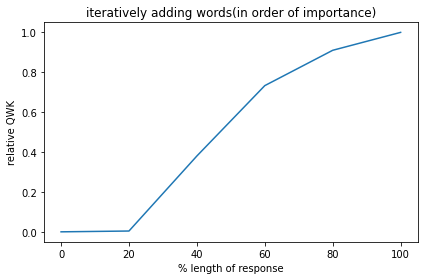

In [36]:
d
plot_and_save(d,ATTRS_DIR+'adding_top', x = '% length of response', y ='relative QWK', title= 'iteratively adding words(in order of importance)')

In [34]:
def bottom_k_attrs(tokens, attrs,k=None):
    k = min(k, len(tokens))
    return ([tokens[i] for i in np.argpartition(attrs, k)[:k]])

d2_keys = []
d2_vals = []
for K in range(0,6):
  percent = K*0.2
  preds_new = []
  new_essay_list = []
  avg_len = 0
  c_list_total = []
  for id, essay in enumerate(essay_list):
    top_k = int(percent* len(attrs_list[id]))
    attrs = attrs_list[id]
    question_tokens = essay_list[id]
    attrs = [abs(x) for x in attrs]
    try:
      c_list = bottom_k_attrs(question_tokens , attrs, k = top_k)
    except Exception as e:
      c_list = list(set(question_tokens))
    if top_k==0:
      c_list = []

    # c_list_total.extend(c_list)
    new_essay = []
    count = 0
    for i in range(len(question_tokens[:len(attrs)])):  
      if question_tokens[:len(attrs)][i] in c_list and count<top_k:
        count+=1
        pass
      else:
        new_essay.append( question_tokens[:len(attrs)][i])
    # avg_len+=len(new_essay)
    # print(len(new_essay)/  len(question_tokens[:len(attrs)]) , new_essay, question_tokens[:len(attrs)])
    
    new_essay = new_essay + [0]*(395 - len(new_essay))
    new_essay_list.append(new_essay)

    # input_df = [np.array([new_essay]), np.array([mem_total[0]]), 1]
    # for i, key in enumerate(INPUT_TENSORS):
    #     feed[key.name] = input_df[i]
    # pred = sess.run(PRED_TENSOR,feed)[0]
    # # print(abs(pred - pred_array_orig[id]))
    # if round(abs(pred - pred_array_orig[id])) == 1:
    #   if id not in p_list.keys():
    #     p_list[id] = percent*100
    #   else:
    #     pass

  avg_len/=len(new_essay_list)
  c_len = len(set(c_list_total))
  feed = {}
  input_df = [np.array(new_essay_list), np.array(mem_total), 1]
  for i, key in enumerate(INPUT_TENSORS):
      feed[key.name] = input_df[i]
  pred = sess.run(PRED_TENSOR,feed)
  preds_new.extend(pred)
  preds_new = [int(x) for x in preds_new]
  
  acc = cohen_kappa_score(preds_new, pred_array_orig, weights='quadratic')
  get_pred_stats(pred_array_orig, preds_new, ATTRS_DIR+'stats_bottom.txt', int(100-percent*100))
  # print(percent*100, avg_len, acc)
  d2_keys.append(100-percent*100)
  d2_vals.append(acc)

In [29]:
l = p_list.values()
sum(l)/len(l)

20.0

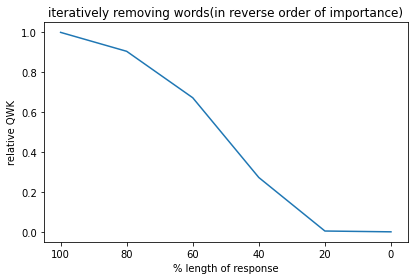

In [32]:
plot_and_save_both(d2_keys, d2_vals, ATTRS_DIR+'removing_bottom', x = '% length of response', y ='relative QWK', title= 'iteratively removing words(in reverse order of importance)')

In [ ]:
import os
import gc
import multiprocessing

def create_model_and_train(low, high, mem, attr_type = 'add'):
  ATTRS_DIR = '/content/drive/MyDrive/IG RESULTS/'
  ATTRS_TSV = ATTRS_DIR+'MEMORY NET/P3/attrs_'+attr_type+'.tsv'
  
  saver = tf.train.import_meta_graph("/content/drive/MyDrive/IG RESULTS/MEM MODELS/"+str(essay_set_id)+"/checkpoints_"+str(fold_no)+"-"+str(step)+".meta")  
  sess = tf.Session()
  saver.restore(sess,"/content/drive/MyDrive/IG RESULTS/MEM MODELS/"+str(essay_set_id)+"/checkpoints_"+str(fold_no)+"-"+str(step))

  graph = tf.get_default_graph()
  IG = integrated_gradients(graph, sess, min = 0, batch_size= 20, num_reps=40)

  data = pd.read_csv(ATTRS_DIR+'big_3_'+attr_type+'.csv')
  essay_list, resolved_scores = load_training_data(data)
  E = data_utils.vectorize_data(essay_list, word_idx, 395)
  
  with open(ATTRS_TSV, 'w') as outf:
    ans = ''
    for i,v in enumerate(E[low:high]):
        tsv_string = ''
        attrs, words= IG.explain(x = E[i][:395], memory= mem)

        question_attrs = []
        for ind in range(len(words)):
          if words[ind] != None and str(attrs[ind])!=None:
            question_attrs.append(
                '|'.join([ words[ind], str(attrs[ind]) ])
                )
        tsv_string = ['||'.join(question_attrs)]
        ans += '\t'.join(tsv_string) + '\n'
        del attrs, words, question_attrs, tsv_string
        gc.collect()
    
    outf.write(ans)
    outf.flush()
    del ans
    gc.collect()
    outf.write('done')
  print('DONE')

In [ ]:
attr_type = 'normal'
ranges = [[0,50], [50,100]]
for r in (ranges):
  p = multiprocessing.Process(target = create_model_and_train, args = (r[0], r[1], m[0][0], attr_type))
  p.start()
  p.join()
  p.terminate()

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE


In [ ]:
attr_type = 'song_beg'
for r in (ranges):
  p = multiprocessing.Process(target = create_model_and_train, args = (r[0], r[1], m[0][0], attr_type))
  p.start()
  p.join()
  p.terminate()

attr_type = 'song_end'
for r in (ranges):
  p = multiprocessing.Process(target = create_model_and_train, args = (r[0], r[1], m[0][0], attr_type))
  p.start()
  p.join()
  p.terminate()

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE


In [ ]:
attr_type = 'false_beg'
for r in (ranges):
  p = multiprocessing.Process(target = create_model_and_train, args = (r[0], r[1], m[0][0], attr_type))
  p.start()
  p.join()
  p.terminate()
  
attr_type = 'false_end'
for r in (ranges):
  p = multiprocessing.Process(target = create_model_and_train, args = (r[0], r[1], m[0][0], attr_type))
  p.start()
  p.join()
  p.terminate()

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE


In [ ]:
attr_type = 'shuffle'
for r in (ranges):
  p = multiprocessing.Process(target = create_model_and_train, args = (r[0], r[1], m[0][0], attr_type))
  p.start()
  p.join()
  p.terminate()

attr_type = 'syn'
for r in (ranges):
  p = multiprocessing.Process(target = create_model_and_train, args = (r[0], r[1], m[0][0], attr_type))
  p.start()
  p.join()
  p.terminate()

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/IG RESULTS/MEM MODELS/3/checkpoints_1-8190
4
DONE


In [ ]:
def get_w_a(essay_type):
  ATTRS_DIR = '/content/drive/MyDrive/IG RESULTS/MEMORY NET/P3/'

  ### NORMAL
  path = ATTRS_DIR + 'attrs_'+essay_type+'.tsv'
  w = []
  a = []

  with open(path, 'r') as f:
    for line in f:
        line = line.strip()
        question_attrs = line.split('\t')[0]
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
          if word_attr != 'done':
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        question_tokens = question_tokens + [None]*(395 - len(attrs))
        attrs = attrs + [0]*(395 - len(attrs))

        w.append(question_tokens)
        a.append(attrs)
  return a[:-1], w[:-1]

In [ ]:
def save_stats_add(diff, diff_attr, percent, output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\npercent of top words in added words:  '+ str(percent))
  result.close()

def save_stats_mod_shuffle(diff, diff_attr, changed_no,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nno of top words which changed attr:  '+ str(changed_no))
  result.close()

def save_stats_mod_syn(diff, diff_attr, changed_top_no,changed_bottom_no, top_words, bottom_words, output_filename):
  result = open(output_filename, 'w')
  result.write('\n diff in scores:  '+str(diff))
  result.write('\n diff in attrs:  '+ str(diff_attr))
  result.write('\n no of top words which changed attr:  '+ str(changed_top_no))
  result.write('\n no of bottom words which changed attr:  '+ str(changed_bottom_no))
  result.write('\n top words which changed attr:  '+ str(top_words))
  result.write('\n bottom words which changed attr:  '+ str(bottom_words))
  result.close()

def subfinder(l, sl):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i])
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i] for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))

    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, k)[:k]:
          tokens_list.append(tokens[i])
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i] for i in np.argpartition(attrs, k)[:k]])

In [ ]:
def save_big_attrs_pdf(memory, essay_type, type_add = False, type_mod = False, type_gen = False):
  ATTRS_DIR = '/content/drive/MyDrive/IG RESULTS/MEMORY NET/P3/'
  dir =  ATTRS_DIR
  if not os.path.exists(dir):
    os.makedirs(dir)

  pattern_none = [None, None, None, None, None]
  
  if type_add:
    diff_array = [] 
    diff_attr_array = []
    percent_array = []

  if type_mod:
    diff_array = []
    diff_attr_array = []
    changed_count_array = []
    changed_count_top_array = []
    changed_count_bottom_array = []
    changed_top_words = {}
    changed_bottom_words = {}

  ### NORMAL
  a, w = get_w_a('normal')
  ### ADV
  a_new, w_new = get_w_a(essay_type)
  
  for i,essay in enumerate(w_new):
    attrs, words= a_new[i], essay
    E = vectorize_data([words], word_idx, 359)
    E_normal = vectorize_data([w[i]], word_idx, 359)
    # assert (E_normal[0]) == (E[0])
    labels_new = (IG.predict([E[0], memory[0],1.0]))
    labels_orig =(IG.predict([E_normal[0], memory[0],1.0]))
    if type_add:
        try:
          loc = subfinder(w[i], pattern_none)[0]
        except Exception as e:
          loc = len(w[i]) 
        try: 
          loc2 = subfinder(words, pattern_none)[0]
        except Exception as e:
          loc2 = len(words)
        # print(loc, loc2, w[i])

        if essay_type == 'song_beg' or essay_type =='false_beg' :
          pattern = w[i][:5]
          try:
            loc_patt = subfinder(words, pattern)[0]
          except Exception as e:
            loc_patt = 0
          new_w = words[:loc_patt]
          new_a = attrs[:loc_patt]
          other_a = attrs[loc_patt:loc2]

        elif essay_type == 'song_end' or essay_type =='false_end':
          new_w = words[loc:loc2]
          new_a = attrs[loc:loc2]
          other_a = attrs[:loc]

        if (new_w) !=[]:
          top_words_orig = top_k_attrs(w[i], a[i], k = int(0.2*loc))
          top_words = top_k_attrs(words , attrs, k = int(0.2*loc2))

          top_words_final = [x for x in top_words if x in new_w]

          diff = int(labels_new) - int(labels_orig)
          diff_array.append(abs(diff))

          diff_attr_frac = []
          for i_attrs in range(0,len(other_a), len(new_a)):
            if i_attrs+len(new_a) < len(other_a):
              diff_attr_frac.append(   sum(other_a[   i_attrs:i_attrs+len(new_a)  ])  )
            else:
              diff_attr_frac.append(   sum(other_a[   i_attrs:len(other_a)  ])  )
              break

          new_diff_frac = sum(diff_attr_frac) / len(diff_attr_frac)

          diff_attr = sum(new_a)/new_diff_frac
          diff_attr_array.append(diff_attr)

          percent = len(top_words_final)/len(new_w)
          percent_array.append(percent)
    
    elif type_mod:
        diff = int(labels_new) - int(labels_orig)
        diff_array.append(abs(diff))

        diff_attr = sum(attrs) - sum(a[i])
        diff_attr_array.append(diff_attr)

        ###### SYN

        if essay_type == 'syn':
          # normal
          loc = subfinder(w[i], pattern_none)[0]
          
          attrs_abs=[]
          attrs_sign_orig =[]
          for x in a[i]:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign_orig.append('+')
            else:
              attrs_sign_orig.append('-')

          top_words_orig, token_signs_orig = top_k_attrs(w[i][:loc], attrs_abs[:loc], attrs_sign_orig[:loc], k = int(0.2*loc))
          bottom_words_orig, bottom_token_signs_orig = bottom_k_attrs(w[i][:loc], attrs_abs[:loc], attrs_sign_orig[:loc], k = int(0.2*loc))
          
          # adv
          loc2 = subfinder(words, pattern_none)[0]
          attrs_abs=[]
          attrs_sign =[]
          for x in attrs:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')
          
          top_words, token_signs = top_k_attrs(words[:loc2], attrs_abs[:loc2], attrs_sign[:loc2], k = int(0.2*loc2))
          bottom_words, bottom_token_signs = bottom_k_attrs(words[:loc2], attrs_abs[:loc2], attrs_sign[:loc2], k = int(0.2*loc2))

          changed_count_top = 0
          changed_count_bottom = 0
          
          # top    
          for orig_index,t in enumerate(top_words_orig):
            try:
              ind = w[i].index(t)
            except Exception as e:
              ind = -1

            if ind!=-1:
              if attrs_sign[ind] != attrs_sign_orig[ind]:
                  changed_count_top+=1
                  changed_top_words[t] = words[ind]
          
          # bottom
          for orig_index,t in enumerate(bottom_words_orig):
            try:
              ind = w[i].index(t)
            except Exception as e:
              ind = -1

            if ind!=-1:
              if attrs_sign[ind] != attrs_sign_orig[ind]:
                  changed_count_bottom+=1
                  changed_bottom_words[t] = words[ind]
          
          changed_count_top_array.append(changed_count_top)
          changed_count_bottom_array.append(changed_count_bottom)

        ###### SHUFFLE 
        if essay_type == 'shuffle':
          loc = subfinder(w[i], pattern_none)[0]
          attrs_abs=[]
          attrs_sign =[]
          for x in a[i]:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')

          top_words_orig, token_signs_orig = top_k_attrs(w[i], attrs_abs, attrs_sign, k = int(0.2*loc))
          
          loc = subfinder(words, pattern_none)[0]
          attrs_abs=[]
          attrs_sign =[]
          for x in attrs:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')
          
          top_words, token_signs = top_k_attrs(words, attrs_abs, attrs_sign, k = int(0.2*loc))
          
          changed_count = 0

          for orig_index,t in enumerate(top_words_orig):
            try:
              ind = top_words.index(t)
            except Exception as e:
              ind = -1

            if ind!=-1:
              if token_signs_orig[orig_index] != token_signs[ind]:
                  changed_count+=1
          changed_count_array.append(changed_count)

  def Average(lst): 
    return sum(lst) / len(lst) 
  
  if type_add:
    save_stats_add(Average(diff_array), Average(diff_attr_array), Average(percent_array),       dir+'stats_'+essay_type+'.txt')

  if type_mod and essay_type == 'syn':
    save_stats_mod_syn(Average(diff_array), Average(diff_attr_array), Average(changed_count_top_array), \
                   Average(changed_count_bottom_array), set(changed_top_words),  set(changed_bottom_words), \
                   dir+'stats_'+essay_type+'.txt')

  if type_mod and essay_type == 'shuffle':
    save_stats_mod_shuffle(Average(diff_array), Average(diff_attr_array), Average(changed_count_array), dir+'stats_'+essay_type+'.txt')

In [ ]:
save_big_attrs_pdf(m[0], 'song_beg', type_add=True)
save_big_attrs_pdf(m[0], 'song_end', type_add=True)
save_big_attrs_pdf(m[0], 'false_beg', type_add=True)
save_big_attrs_pdf(m[0], 'false_end', type_add=True)

In [ ]:
save_big_attrs_pdf(m[0], 'shuffle', type_mod=True)

In [ ]:
save_big_attrs_pdf(m[0], 'syn', type_mod=True)

In [ ]:
from sklearn.metrics import cohen_kappa_score
for i,v in enumerate(orig_array):
      orig_array[i] = v+0
orig_acc = cohen_kappa_score(test_scores, orig_array, weights='quadratic')
orig_acc

0.6650977415069272

In [ ]:
curve_data = {}
question_lengths = {}
all_accs = []
counts_list,_ = get_counts_list(top_k = None)
counts_list = [item for sublist in counts_list for item in sublist]
c = (counts_list)
with open('/content/drive/My Drive/IG RESULTS/MEM MODELS/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
for K in np.append(0, np.unique(np.floor(np.geomspace(1, len(c), 10)))):
    # take K most top attributed words
    if K in curve_data:
        continue
    
    counts_list,_ = get_counts_list(int(K))
    counts_list = [item for sublist in counts_list for item in sublist]

    whitelist = set([tokenizer[w] for w in counts_list[:int(K)]]) if K > 0 else set()
    print('wh len', len(whitelist))
    num_batches = 0
    avg_question_length_orig = 0
    avg_question_length_new = 0
    num_questions = 0
    pred_array = []
    # iterator over the validation dataset
    for test,mem in (zip(t,m)):

        test = np.array(test)
        new_test = np.zeros(test.shape)
        curr_batch_size = int(test.shape[0])
        for batch_i in range(curr_batch_size):
            len_counter = 0
            # avg_question_length_orig += int(test[batch_i])
            for word_i, w in enumerate(test[batch_i]):
                if int(w) in whitelist:
                    new_test[batch_i, len_counter] = int(w)
                    len_counter += 1
            if len_counter == 0:
                len_counter = 1
            avg_question_length_new += int(len_counter)
            num_questions += 1
            
        feed = {}
        input_df = [new_test, mem, 1]
        for i, key in enumerate(INPUT_TENSORS):
            feed[key.name] = input_df[i]
        pred = sess.run(PRED_TENSOR,feed)
        pred_array.extend(pred)

    # print("avg question length orig: ", float(avg_question_length_orig)/num_questions)
    print("avg question length new: ", float(avg_question_length_new)/num_questions)
    for i,v in enumerate(pred_array):
      pred_array[i] = v+0
    acc = cohen_kappa_score(pred_array, test_scores, weights='quadratic')
    print("accuracy for ", K, " is", acc)
    curve_data[K] = acc
    question_lengths[K] = float(avg_question_length_new)/num_questions

wh len 0
avg question length new:  1.0
accuracy for  0.0  is 0.0
wh len 1
avg question length new:  1.0144508670520231
accuracy for  1.0  is 0.0
wh len 3
avg question length new:  1.106936416184971
accuracy for  3.0  is 0.0
wh len 8
avg question length new:  5.054913294797688
accuracy for  10.0  is 0.0
wh len 21
avg question length new:  19.320809248554912
accuracy for  33.0  is 0.004930156121610518
wh len 62
avg question length new:  44.0635838150289
accuracy for  108.0  is 0.3178705330584801
wh len 175
avg question length new:  69.46531791907515
accuracy for  351.0  is 0.4944507532742827
wh len 370
avg question length new:  87.9364161849711
accuracy for  1134.0  is 0.5764614557831254
wh len 727
avg question length new:  99.91618497109826
accuracy for  3663.0  is 0.6421445155843242
wh len 1191
avg question length new:  106.61849710982659
accuracy for  11830.0  is 0.6770729068037333
wh len 1504
avg question length new:  109.23699421965318
accuracy for  38205.0  is 0.6678660132912667


In [ ]:
curve_data = {}
question_lengths = {}
all_accs = []
counts_list,_ = get_counts_list(top_k = None)
counts_list = [item for sublist in counts_list for item in sublist]
c = (counts_list)
with open('/content/drive/My Drive/IG RESULTS/MEM MODELS/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
for K in np.append(0, np.unique(np.floor(np.geomspace(1, len(c), 10)))):
    # take K most top attributed words
    if K in curve_data:
        continue
    
    counts_list,_ = get_counts_list(int(K))
    counts_list = [item for sublist in counts_list for item in sublist]

    whitelist = set([tokenizer[w] for w in counts_list[:int(K)]]) if K > 0 else set()
    print('wh len', len(whitelist))
    num_batches = 0
    avg_question_length_orig = 0
    avg_question_length_new = 0
    num_questions = 0
    pred_array = []
    # iterator over the validation dataset
    for test,mem in (zip(t,m)):

        test = np.array(test)
        new_test = np.zeros(test.shape)
        curr_batch_size = int(test.shape[0])
        for batch_i in range(curr_batch_size):
            len_counter = 0
            # avg_question_length_orig += int(test[batch_i])
            for word_i, w in enumerate(test[batch_i]):
                if int(w) in whitelist:
                    new_test[batch_i, len_counter] = int(w)
                    len_counter += 1
            if len_counter == 0:
                len_counter = 1
            avg_question_length_new += int(len_counter)
            num_questions += 1
            
        feed = {}
        input_df = [new_test, mem, 1]
        for i, key in enumerate(INPUT_TENSORS):
            feed[key.name] = input_df[i]
        pred = sess.run(PRED_TENSOR,feed)
        pred_array.extend(pred)

    # print("avg question length orig: ", float(avg_question_length_orig)/num_questions)
    print("avg question length new: ", float(avg_question_length_new)/num_questions)
    for i,v in enumerate(pred_array):
      pred_array[i] = v+0
    acc = cohen_kappa_score(pred_array, test_scores, weights='quadratic')
    print("accuracy for ", K, " is", acc)
    curve_data[K] = acc
    question_lengths[K] = float(avg_question_length_new)/num_questions

In [ ]:
s= {}
l = len(attrs)
for i in range(0, len(attrs), l//5):
  s[(i)] = sum(attrs[i: i+ l//5])

{0: 0.47054603821015917, 79: 0.0447394315560814, 158: 0.0, 237: 0.0, 316: 0.0}

In [ ]:
for name in names:
  e = E_list[name]
  mem = M_list[name]
  save_attrs_pdf(e, mem, labels_orig, name)

prediction is 0.6202964782714844
baseline_prediction is 0.01159109827131033
delta_prediction is 0.6087054014205933
sum_attributions are 0.6236211061477661
Error percentage is -2.450397958086566
prediction is 0.9031385183334351
baseline_prediction is 0.01159109827131033
delta_prediction is 0.891547441482544
sum_attributions are 0.9108295440673828
Error percentage is -2.1627679793208627
prediction is 0.9022407531738281
baseline_prediction is 0.8223961591720581
delta_prediction is 0.07984459400177002
sum_attributions are -0.6018960475921631
Error percentage is 853.8344394096613
prediction is 0.8502042293548584
baseline_prediction is 0.8223961591720581
delta_prediction is 0.027808070182800293
sum_attributions are -0.4673089385032654
Error percentage is 1780.4795709711022
prediction is 0.873424232006073
baseline_prediction is 0.01159109827131033
delta_prediction is 0.8618331551551819
sum_attributions are 0.8801319003105164
Error percentage is -2.1232352278254596
prediction is 0.838582813739

In [ ]:
# # ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/P1/MEMORY NET/attrs_1_new.tsv'
# # with open(ATTRS_TSV, 'a') as outf:
# c = 1
# ans = ''
# for test,mem in tqdm(zip(t,m)): 
#   # IG = integrated_gradients(graph, sess, min = 1, batch_size= 20, num_reps=20)
#   for j in range(len(test)):   
#       if c<= 271:
#         c+=1
#         continue  

#       question_attrs = []
#       tsv_string= ''
#       attrs, words= IG.explain(x = test[j], memory= mem[j], debug=False)
#       for ind in range(len(words)):
#         if words[ind] is not None:
#             question_attrs.append(
#                 '|'.join([ words[ind], str(attrs[ind]) ])
#                 )
#       tsv_string = ['||'.join(question_attrs)]
#       ans += '\t'.join(tsv_string) + '\n'
#       del attrs, words, question_attrs, tsv_string
#       gc.collect()
#       c+=1
      
#   if  c>271:
#     with open(ATTRS_TSV, 'a') as outf:
#       outf.write(ans)
#     print(c)
#   # del ans, IG
#   # gc.collect()

In [ ]:
ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/MEMORY NET/P7/attrs.tsv'
ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/MEMORY NET/P7/'
from collections import Counter

counts_list = []
top_k = 10
with open(ATTRS_TSV) as f:
    for line in f:
        line = line.strip()
        question_attrs = line.split('\t')[0]
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        k = min(top_k, len(question_tokens))
        # get top k words by attribution 
        counts_list.append([question_tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

flat_counts_list = [item for sublist in counts_list for item in sublist]
frequent_attributions = Counter(flat_counts_list)

with open(ATTRS_DIR+'highest_attrs.txt', 'w') as f:
  attr_to_save = frequent_attributions.most_common(10)
  f.write(str(attr_to_save))

In [ ]:
frequent_attributions = Counter(counts_list)
frequent_attributions

In [ ]:
w1 = graph.get_tensor_by_name("input/question:0")
w2 = graph.get_tensor_by_name("input/memory_key:0")
w3 = graph.get_tensor_by_name("input/keep_prob:0")
INPUT_TENSORS = [w1,w2,w3]
PRED_TENSOR = graph.get_tensor_by_name('prediction/predict_op:0')

In [ ]:
orig_array =[] 
for test,mem in (zip(t,m)):

        test = np.array(test)
        feed = {}
        input_df = [test, mem, 1]
        # baseline = np.zeros(test.shape)
        # baseline_mem = np.zeros(np.array(mem).shape)
        # input_df = [baseline, np.array(mem), 1]
      
        for i, key in enumerate(INPUT_TENSORS):
            feed[key.name] = input_df[i]
        pred = sess.run(PRED_TENSOR,feed)
        orig_array.extend(pred)
# orig_array

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
for i,v in enumerate(orig_array):
      orig_array[i] = v+2
orig_acc = cohen_kappa_score(test_scores, orig_array, weights='quadratic')
orig_acc

0.7867273787473417

In [ ]:
curve_data = {}
question_lengths = {}
all_accs = []
with open('/content/drive/My Drive/IG RESULTS/MEM MODELS/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
for K in np.append(0, np.unique(np.floor(np.geomspace(1, len(Counter(counts_list)), 10)))):
    # take K most top attributed words
    if K in curve_data:
        continue
    whitelist = set([tokenizer[w] for w in counts_list[:int(K)]]) if K > 0 else set()
    print('wh len', len(whitelist))
    num_batches = 0
    avg_question_length_orig = 0
    avg_question_length_new = 0
    num_questions = 0
    pred_array = []
    # iterator over the validation dataset
    for test,mem in (zip(t,m)):

        test = np.array(test)
        new_test = np.zeros(test.shape)
        curr_batch_size = int(test.shape[0])
        for batch_i in range(curr_batch_size):
            len_counter = 0
            # avg_question_length_orig += int(test[batch_i])
            for word_i, w in enumerate(test[batch_i]):
                if int(w) in whitelist:
                    new_test[batch_i, len_counter] = int(w)
                    len_counter += 1
            if len_counter == 0:
                len_counter = 1
            avg_question_length_new += int(len_counter)
            num_questions += 1
            
        feed = {}
        input_df = [new_test, mem, 1]
        for i, key in enumerate(INPUT_TENSORS):
            feed[key.name] = input_df[i]
        pred = sess.run(PRED_TENSOR,feed)
        pred_array.extend(pred)

    # print("avg question length orig: ", float(avg_question_length_orig)/num_questions)
    print("avg question length new: ", float(avg_question_length_new)/num_questions)
    for i,v in enumerate(pred_array):
      pred_array[i] = v+2
    acc = cohen_kappa_score(pred_array, test_scores, weights='quadratic')
    print("accuracy for ", K, " is", acc)
    curve_data[K] = acc
    question_lengths[K] = float(avg_question_length_new)/num_questions

wh len 0
avg question length new:  1.0
accuracy for  0.0  is 0.0
wh len 1
avg question length new:  1.0
accuracy for  1.0  is 0.0
wh len 2
avg question length new:  1.0336134453781514
accuracy for  2.0  is 0.0
wh len 5
avg question length new:  2.316526610644258
accuracy for  5.0  is 0.00015103991478160328
wh len 13
avg question length new:  20.142857142857142
accuracy for  13.0  is 0.010327873085193895
wh len 26
avg question length new:  66.57422969187675
accuracy for  30.0  is 0.17700315687596768
wh len 49
avg question length new:  94.96918767507003
accuracy for  72.0  is 0.1964733462440118
wh len 81
avg question length new:  122.70868347338936
accuracy for  170.0  is 0.2035830142911419
wh len 151
avg question length new:  228.4173669467787
accuracy for  400.0  is 0.49563840479396215
wh len 256
avg question length new:  264.9495798319328
accuracy for  942.0  is 0.5342666714044233
wh len 425
avg question length new:  293.8347338935574
accuracy for  2218.0  is 0.5900155373910694


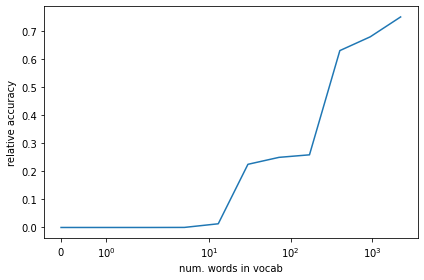

In [ ]:
import matplotlib.pyplot as plt
OVERSTABILITY_CURVE_FILE = 'over_1.eps'
plt.plot(list(curve_data.keys()), list(curve_data.values())/orig_acc)
plt.xscale('symlog')
plt.xlabel('num. words in vocab')
plt.ylabel('relative accuracy')
plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
plt.tight_layout()
plt.show()

In [ ]:
ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/P1/MEMORY NET/attrs_1_new.tsv'
with open(ATTRS_TSV, 'a') as outf:
  c = 1
  for test,mem in tqdm(zip(t,m)): 
    ans = ''
    IG = integrated_gradients(graph, sess, min = 2, batch_size= 20, num_reps=20)
    for j in range(len(test)):
        question_attrs = []
        tsv_string= ''
        attrs, words= IG.explain(x = test[j], memory= mem[j], debug=False)
        for ind in range(len(words)):
          if words[ind] is not None:
              question_attrs.append(
                  '|'.join([ words[ind], str(attrs[ind]) ])
                  )
        tsv_string = ['||'.join(question_attrs)]
        ans += '\t'.join(tsv_string) + '\n'
        del attrs, words, question_attrs, tsv_string
        gc.collect()
        c+=1
        print(c)
    outf.write(ans)
    outf.flush()
    del ans, IG
    gc.collect()


0it [00:00, ?it/s]

2
3
4
5
6
7
8
9
10
11
12
13
14
15



1it [01:55, 115.85s/it]

16
17
18
19
20
21
22
23
24
25
26
27
28
29
30



2it [04:41, 130.90s/it]

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45



3it [08:19, 157.04s/it]

46
47
48
49
50
51
52
53
54
55
56
57
58
59
60



4it [12:43, 188.90s/it]

61
62
63
64
65
66
67
68
69
70
71
72
73
74
75



5it [18:02, 228.18s/it]

76
77
78
79
80
81
82
83
84
85
86
87
88
89
90



6it [24:22, 273.73s/it]

91
92
93
94
95
96
97
98
99
100
101
102
103
104
105



7it [31:28, 319.38s/it]

106
107
108
109
110
111
112
113
114
115
116
117
118
119
120



8it [39:23, 365.93s/it]

121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136



9it [48:24, 418.39s/it]

137
138
139
140
141
142
143
144
145
146
147
148
149
150
151



10it [58:10, 468.90s/it]

152
153
154
155
156
157
158
159
160
161
162
163
164
165
166



11it [1:08:46, 518.78s/it]

167
168
169
170
171
172
173
174
175
176
177
178
179
180
181



12it [1:20:57, 582.42s/it]

182
183
184
185
186
187
188
189
190
191
192
193
194
195
196



13it [1:34:25, 650.21s/it]

197
198
199
200
201
202
203
204
205
206
207
208
209
210
211



14it [1:48:30, 708.67s/it]

212
213
214
215
216
217
218
219
220
221
222
223
224
225
226



15it [2:03:25, 764.66s/it]

227
228
229
230
231
232
233
234
235
236
237
238
239
240
241



16it [2:19:07, 817.63s/it]

242
243
244
245
246
247
248
249
250
251
252
253
254
255
256



17it [2:35:40, 870.40s/it]

257
258
259
260
261
262
263
264
265
266
267
268
269
270
271



18it [2:53:02, 921.83s/it]

272
273
274
275
276
277
278
279
280
281
282
283
284
285
286



19it [3:11:20, 974.72s/it]

287
288
289
290
291
292
293
294
295
296
297
298
299
300
301



20it [3:30:31, 1027.61s/it]

302
303
304
305
306
307
308


In [ ]:
###### MAIN RUN
import time
start = time.time()
c = 1
for test,mem in zip(t,m): 
  for j in range(len(test)):
    out = IG.explain(x = test[j], memory= mem[j], debug=False) ## debug for errors
    convert_html_to_pdf(out, ATTRS_DIR+str(fold_no)+'_'+str(c)+'.pdf')
    c+=1
end = time.time()
print(start-end)

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive\
(file_id='1CIEpiDmzLmJ6LMCVSOmCKw_eOg4ocuS4', dest_path='/content/AES.zip', unzip=True)


In [ ]:
import nltk
from nltk import tokenize
import pickle
from random import shuffle
import random

In [ ]:
def create_adv_data(data_test, file_path):	
    def rindex(lst, value):
      lst.reverse()
      i = lst.index(value)
      lst.reverse()
      return len(lst) - i - 1
    
    with open('/content/calling-out-bluff/'+file_path, 'rb') as handle:
        songs= pickle.load(handle)
    song_list = []
    for i in songs:
      song_sents = tokenize.sent_tokenize(i)
      song_list.extend(song_sents)
    
    song_lyrics = []
    for x in song_list:
      a = []
      for w in tokenize.word_tokenize(x):
        try:
          a.append(tokenizer[w.lower()])
        except:
          a.append(0)
      song_lyrics.append(a)
    
    songs_beg=[]
    mem_beg = []
    songs_end=[]
    mem_end = []
    
    for r in data_test:
      test = r[0]
      mem = r[1]
      for i,r in enumerate(test):
        if 0 in r:
          ind = rindex(r.tolist(), 0)
        else:
          ind = 0
        ar = random.sample(song_lyrics, 20)
        ar = [x for sublist in ar for x in sublist]
        ar = ar[:ind+1]
        songs_beg.append(ar + r[ind+1:].tolist())
        songs_end.append(r[ind+1:].tolist() + ar)
        mem_beg.append(mem[i])
        mem_end.append(mem[i])
    
    song_beg_data = pad_sequences(songs_beg, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre', truncating='pre') #padding to max_length
    song_end_data = pad_sequences(songs_end, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post', truncating='post') #padding to max_length
    return song_beg_data, song_end_data, mem_beg, mem_end

In [ ]:
def predict_and_score_save(model, beg, end, orig, f_name, prompt, data=None):
    def npos(orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]>orig[i]:
          count+=1 
      return count

    def nneg(orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]<orig[i]:
          count+=1 
      return count

    def nsame(orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]==orig[i]:
          count+=1 
      return count

    def mu(orig, new):
      s=0
      n = len(orig)
      for i in range(n):
        s+=(orig[i] - new[i])
      return s/n

    def absmu(orig, new):
      s=0
      n = len(orig)
      for i in range(n):
        s+=(orig[i] - new[i])
      return abs(s)/n

    def sd(orig, new):
      mu_val = mu(orig, new)
      s=0
      n = len(orig)
      for i in range(n):
        s+=(orig[i] - new[i] - mu_val)**2
      return (s/n)**(1/2)

    def muneg(orig, new):
      s=0
      n = len(orig)
      for i in range(n):
        if orig[i] < new[i]:
          s+=-(orig[i] - new[i])
      return s/n

    def mupos(orig, new):
      s=0
      n = len(orig)
      for i in range(n):
        if orig[i] > new[i]:
          s+=-(orig[i] - new[i])
      return s/n
    
    def get_pred_stats(orig, new):
      a = ('kappa', cohen_kappa_score(orig, new, weights='quadratic'))
      b = ('NPOS', npos(orig, new))
      c = ('NNEG', nneg(orig, new))
      d = ('NSAME', nsame(orig, new))
      e = ('MU', mu(orig, new))
      f = ('ABSMU', absmu(orig, new))
      g = ('SD', sd(orig, new))
      h = ('MUPOS', mupos(orig, new))
      i = ('MUNEG', muneg(orig, new))
      return [a,b,c,d,e,f,g,h,i]

    beg_preds = []
    for test,mem in beg:

        feed = {}
        input_df = [test, mem, 1]
        for i, key in enumerate(INPUT_TENSORS):
            feed[key.name] = input_df[i]
        pred = sess.run(PRED_TENSOR,feed)
        beg_preds.extend(pred)
    
    end_preds = []
    for test,mem in end:

        feed = {}
        input_df = [test, mem, 1]
        for i, key in enumerate(INPUT_TENSORS):
            feed[key.name] = input_df[i]
        pred = sess.run(PRED_TENSOR,feed)
        end_preds.extend(pred)

    beg_fin =[a+2 for a in beg_preds.flatten().tolist()]
    end_fin =[a+2 for a in end_preds.flatten().tolist()]
    # y_pred_fin =  [int(round(a*(range_max-range_min)+range_min)) for a in main_preds.flatten().tolist()]
    orig_fin =   [int(a) for a in orig]
    return (beg_fin, end_fin, orig_fin)
    # print(, orig_fin)

    # with open('/content/drive/My Drive/IG RESULTS/P'+prompt+'/SKIPFLOW/ADV/'+f_name+'_results_'+prompt+'.txt', 'w') as f:
    #   f.write(str(get_pred_stats(orig_fin, beg_fin)))
    #   f.write(str(get_pred_stats(orig_fin, end_fin)))

In [ ]:
def store_attr(f_name, data, prompt, n =10):
  import os
  import gc
  ATTRS_TSV = './drive/My Drive/IG RESULTS/P'+prompt+'/MEMORY NET/attrs_stor_'+f_name+'.tsv'
  ATTRS_DIR = './drive/My Drive/IG RESULTS/P'+prompt+'/MEMORY NET/'+f_name+'/'
  if os.path.isdir(ATTRS_DIR):
    pass
  else:
    os.mkdir(ATTRS_DIR)
  with open(ATTRS_DIR+f_name+'.pkl', 'wb') as f:
    pickle.dump(data,f)
  batch = 1
  with open(ATTRS_TSV, 'a') as outf:
    c=0
    while c<n:
      ans = ''
      for i,v in enumerate(data[c:c+batch]):
          tsv_string = ''
          attrs = get_attributions(np.array([v]))[0]
          words,count = sequence_to_text(v)
          assert len(words[count:]) == len(attrs[count:])
          question_attrs = []
          html = vis(attrs[count:], words[count:])
          convert_html_to_pdf(html, ATTRS_DIR+str(c)+'.pdf')
          for ind in range(len(words[count:])):
            # print( '|'.join([ words[count:][ind], str(attrs[count:][ind]) ]))
            if words[count:][ind] != None and str(attrs[count:][ind])!=None:
              question_attrs.append(
                  '|'.join([ words[count:][ind], str(attrs[count:][ind]) ])
                  )
          tsv_string = ['||'.join(question_attrs)]
          ans += '\t'.join(tsv_string) + '\n'
          del attrs, words, question_attrs, tsv_string
          gc.collect()
      c+=batch
      outf.write(ans)
      outf.flush()
      del ans
      gc.collect()
    outf.write('done')
  print('DONE')

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
songs_beg, songs_end = create_adv_data([t,m], 'song.pickle')
speech_beg, speech_end = create_adv_data([t,m], 'speeches.pickle')
truth_beg, truth_end = create_adv_data([t,m], 'un_truth.pickle')
false_beg, false_end = create_adv_data([t,m], 'un_false.pickle')

AttributeError: ignored

In [ ]:
f_names = ['song_beg', 'song_end', 'speech_beg', 'speech_end', 'truth_beg', 'truth_end', 'false_beg', 'false_end']
datas = [songs_beg, songs_end, speech_beg, speech_end, truth_beg, truth_end,  false_beg, false_end]
for i in range(len(f_names)):
  store_attr(f_names[i], datas[i],prompt =str(1),n=10)

In [ ]:
range_max =12
range_min =2